# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [3]:
from relaxed.plot_defaults import *

In [4]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split


In [5]:
from relaxed.analysis import setup, get_quantiles, gaussian_conditional, get_am, get_an_from_am, get_lam

# Data

In [13]:
# catalog
hcat, indices, scales = setup('m11', path='../../../output/30k')
xoff = hcat.cat['xoff']
cvir = hcat.cat['cvir']
eta = hcat.cat['eta']

# obtain a_m
am, mass_bins = get_am('m11', min_mass=0.1, path='../../../output/30k')
a2 = get_an_from_am(am, mass_bins)

# throw away first & last, useless bin (a = 1.00 always for that)
am = am[:, 1:-1]
mass_bins = mass_bins[1:-1]
print(am.shape, mass_bins.shape, a2.shape, cvir.shape, xoff.shape, eta.shape)

(30000, 98) (98,) (30000,) (30000,) (30000,) (30000,)


In [14]:
 # remove nan's from lam along the way, like ~1k haloes.
keep, lam, cvir, a2, xoff, eta = get_lam(am, cvir, a2, xoff, eta)
am = am[keep]
print(sum(keep), lam.shape, cvir.shape, a2.shape, am.shape, xoff.shape, eta.shape)

28366 (28366, 98) (28366,) (28366,) (28366, 98) (28366,) (28366,)


In [15]:
# train/test split.
lam_train, lam_test, cvir_train, cvir_test,\
a2_train, a2_test, am_train, am_test, \
xoff_train, xoff_test, eta_train, eta_test = train_test_split(lam, cvir, a2, am, xoff, eta, test_size=0.2)
print(cvir_train.shape)
print(cvir_test.shape)

(22692,)
(5674,)


# Train

In [34]:
from relaxed.analysis import training_suite

In [41]:
extra_args = {'cam_order': -1, 'mass_bins': mass_bins, 'mrange':(.498, 0.51), 'am_train': am_train}
cvir_models = training_suite(am_train, cvir_train, suite=("LN-RS", "CAM", "MG-A2", "MV-LLR", "MV-LR", "MG-TFC", "MV-TLR"), extra_args=extra_args)

In [42]:
extra_args = {'cam_order': +1, 'mass_bins': mass_bins, 'mrange':(0.73, 0.74), 'am_train': am_train}
xoff_models = training_suite(am_train, xoff_train, suite=("LN-RS", "CAM", "MG-A2", "MV-LLR", "MV-LR", "MG-TFC", "MV-TLR"), extra_args=extra_args)

In [43]:
extra_args = {'cam_order': +1, 'mass_bins': mass_bins, 'mrange':(0.73, 0.74), 'am_train': am_train}
eta_models = training_suite(am_train, eta_train, suite=("LN-RS", "CAM", "MG-A2", "MV-LLR", "MV-LR", "MG-TFC", "MV-TLR"), extra_args=extra_args)

# Plots

## Combined histogram of residuals

In [65]:
# funcs are trained functions that take in lam_test and return cvir_pred, colors are color for each function.
def combined_histogram(am_test, X_test, trained_models, colors=('r', 'b', 'g'), models=("CAM"), names=("\\rm CAM"),
                       n_bins=31, latex_var="", xrange=(-2, 2)):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    bins = None
    correlations = []
    for i, m in enumerate(models): 
        model = trained_models[m]
        X_pred = model(am_test, am_test=am_test)
        x = (X_pred - X_test) / X_test
        if bins is None: 
            bins = get_bins(x, range=xrange, bins=n_bins) # share bins between all histograms.
        draw_histogram(ax, x, vline=None, label=names[i], color=colors[i], 
                       bins=bins, density=False)
        
        print(f'{models[i]} corr: {scipy.stats.spearmanr(X_pred, X_test)[0]}')
        
    ax.axvline(0, color='k', ls='--')
    ax.legend(prop={'size':24})
    ax.set_ylabel(r"\rm Counts", size=28)
    
    v_pred = latex_var + r"^{\rm pred}"
    v_test = latex_var + r"^{\rm true}"
    
    ax.set_xlabel(f"$({v_pred} - {v_test}) / {v_test}$", size=28)

### Cvir

MV-TLR corr: 0.7691501586145201
LN-RS corr: -0.018744152201681054
CAM corr: 0.6877194390035394


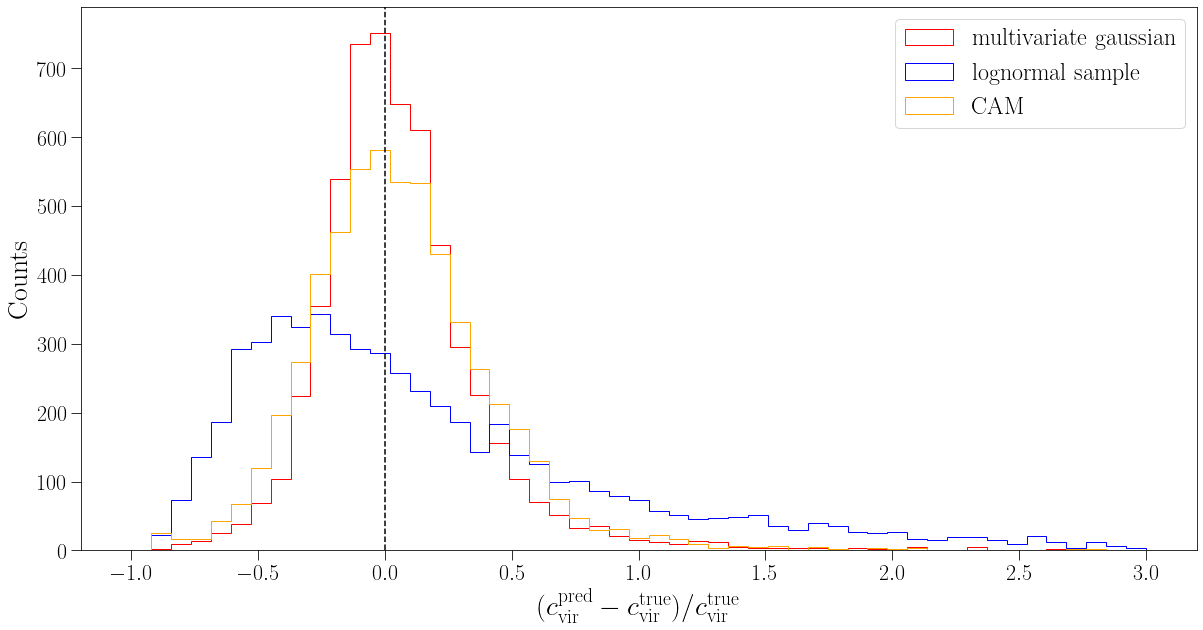

In [66]:
models = ['MV-TLR', 'LN-RS', 'CAM']
names = ["\\rm multivariate gaussian", "\\rm lognormal sample", "\\rm CAM"]
colors = ['r', 'b', 'orange']
combined_histogram(am_test, cvir_test, cvir_models, colors=colors, names=names, models=models, 
                   latex_var=r'c_{\rm vir}', n_bins=51, xrange=(-1, 3))

MV-LR corr: 0.731200874954609
MV-TLR corr: 0.7691501586145201


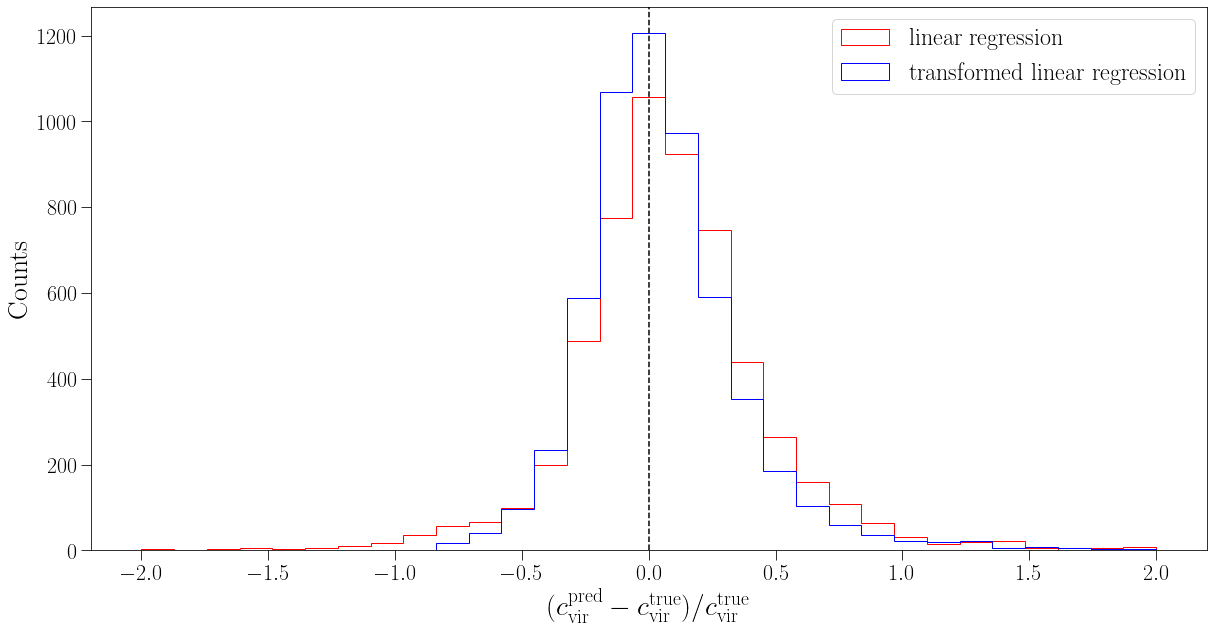

In [68]:
models = ["MV-LR", "MV-TLR"]
names = ['\\rm linear regression', '\\rm transformed linear regression']
colors = ['r', 'b']
combined_histogram(am_test, cvir_test, cvir_models, colors=colors, names=names, models=models, latex_var=r'c_{\rm vir}')

# we note that the quantile transformer is actually doing work in finding an optimal subspace in which to do the regression.

### Xoff

MV-TLR corr: 0.5542123981501509
LN-RS corr: -0.0012113210755927352
CAM corr: 0.5191374783288821


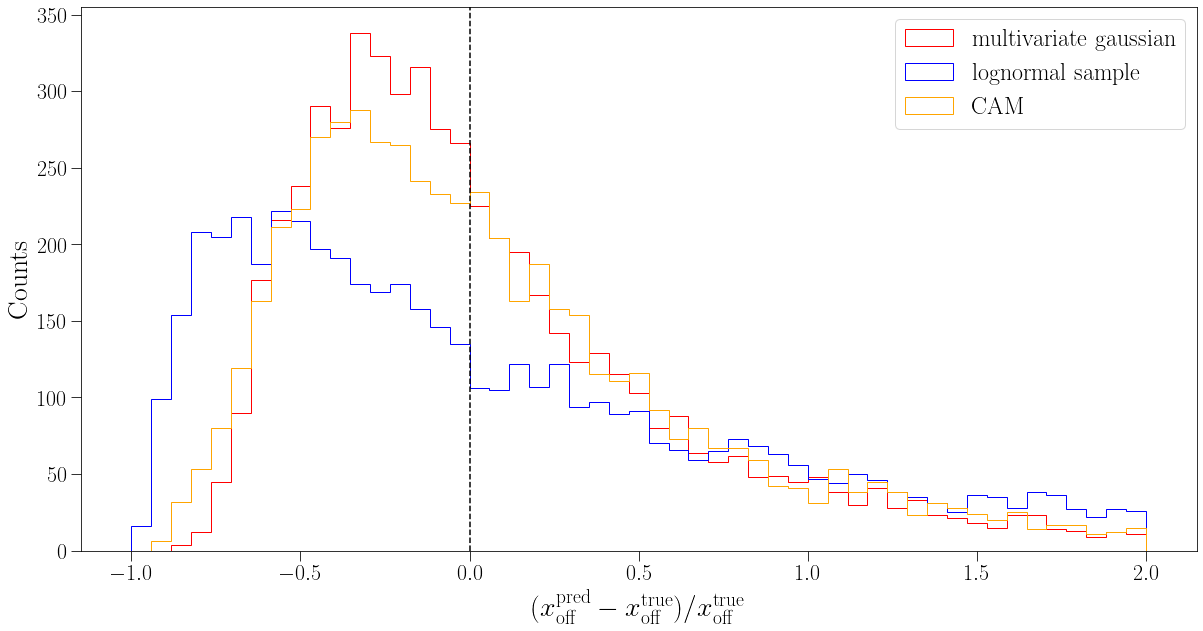

In [69]:
models = ['MV-TLR', 'LN-RS', 'CAM']
names = ["\\rm multivariate gaussian", "\\rm lognormal sample", "\\rm CAM"]
colors = ['r', 'b', 'orange']
combined_histogram(am_test, xoff_test, xoff_models, colors=colors, names=names, models=models, latex_var=r'x_{\rm off}', 
                   n_bins=51, xrange=(-1, 2))

### eta

MV-TLR corr: 0.7216711106779321
LN-RS corr: -0.01805441564764676
CAM corr: 0.6158697587141599


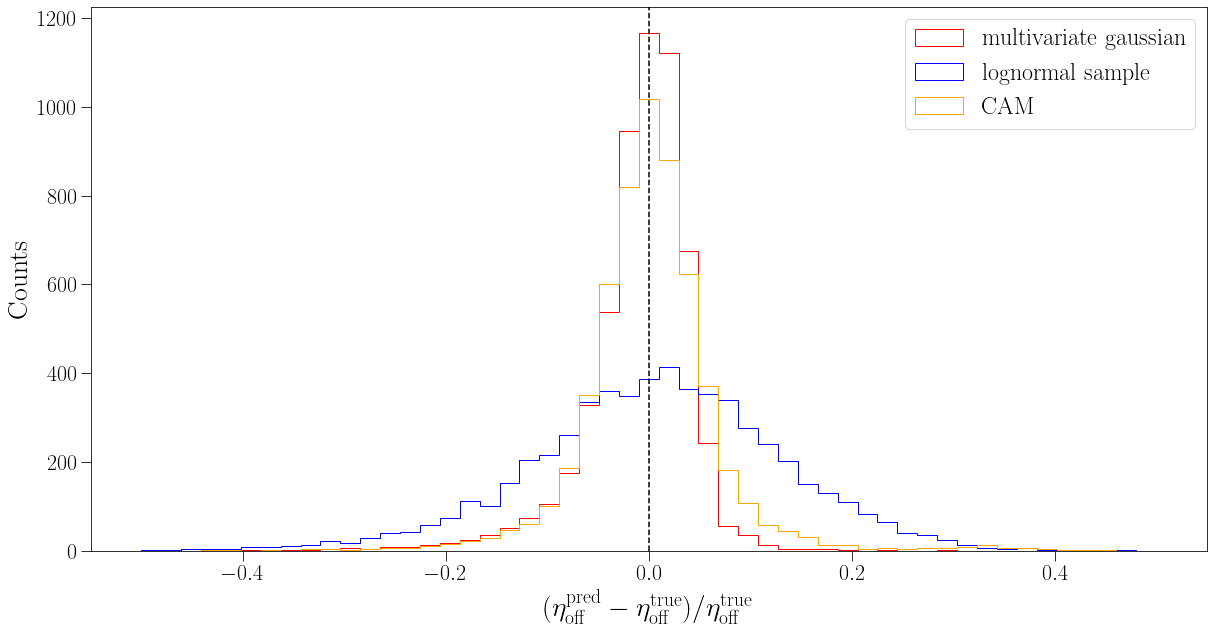

In [71]:
models = ['MV-TLR', 'LN-RS', 'CAM']
names = ["\\rm multivariate gaussian", "\\rm lognormal sample", "\\rm CAM"]
colors = ['r', 'b', 'orange']
combined_histogram(am_test, eta_test, eta_models, colors=colors, names=names, models=models, latex_var=r'\eta_{\rm off}', 
                   n_bins=51,
                   xrange=(-0.5, 0.5))

## Scatter plots of residuals

In [48]:
def scatter_plots(lam_test, X_test, trained_models, colors=('r',), names=('CAM',), alpha=0.5, latex_var=""): 
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))
    ax1, ax2, ax3 = axes.flatten()
    for i, name in enumerate(names): 
        model = trained_models[name]
        X_pred = model(lam_test)
        a_2_test = get_a2_from_am(np.exp(lam_test), mass_bins)
        x = X_pred / X_test
        
        v_true = latex_var + r"^{\rm true}"
        v_pred = latex_var + r"^{\rm pred}"
        
        ax1.scatter(X_test, x, alpha=alpha, color=colors[i], label=name)
        ax1.set_xlabel(f"${v_true}$")
        ax1.set_ylabel(f"${v_pred}/ {v_true}$")
        
        
        ax2.scatter(X_pred, x, alpha=alpha, color=colors[i], label=name)
        ax2.set_xlabel(f"${v_pred}$")
        ax2.set_ylabel(f"${v_pred}/ {v_true}$") 
    
        ax3.scatter(a_2_test, x, alpha=alpha, color=colors[i], label=name)
        ax3.set_xlabel(r"$a_{1/2}^{\rm true}$")
        ax3.set_ylabel(f"${v_pred}/ {v_true}$") 
        
        # add median line
        print(f'median {name}: ', np.median(x))
        ax1.axhline(1, ls='--', color='k')
        ax2.axhline(1, ls='--', color='k')
        ax3.axhline(1, ls='--', color='k')

        # set scales.
        ax1.set_xscale('log')
        ax2.set_xscale('log')
        
        ax1.set_yscale('log')
        ax2.set_yscale('log')
        ax3.set_yscale('log')
        
        ax1.legend()
    plt.tight_layout()

median MV-LLR:  0.9968353249568148
median LN-RS:  0.9734207208635646
median CAM:  1.0172717888014475
median MG-TFC:  1.008432919808826


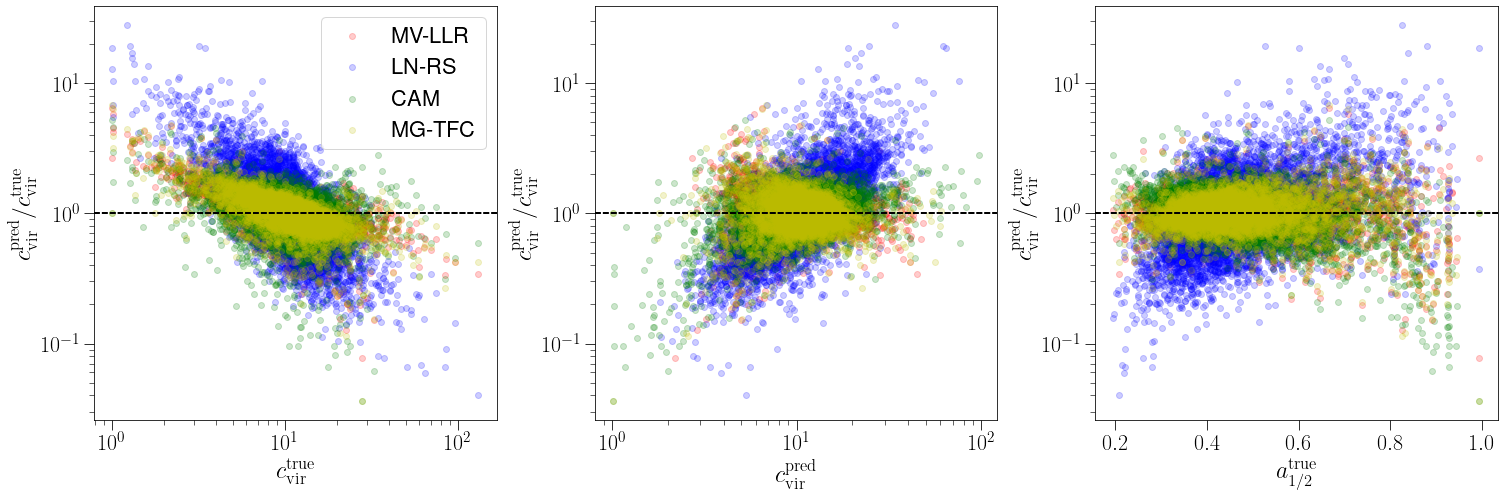

In [49]:
names = ['MV-LLR', 'LN-RS', 'CAM', 'MG-TFC']
colors = ['r', 'b', 'g', 'y']
scatter_plots(lam_test, cvir_test, cvir_models, names=names, colors=colors, alpha=0.2, latex_var=r'c_{\rm vir}')

## Median bin statistic

In [50]:
def make_scatter_binning(ax, x, y, n_xbins=15, bin_bds=None, show_bands=True, color='r', label=''):

    if bin_bds is not None:
        # ignore n_xbins
        size = len(bin_bds) - 1
        x_bds = np.array([(bin_bds[i], bin_bds[i + 1]) for i in range(size)])
    else:
        # divide uniformly.
        xs = np.linspace(np.min(x), np.max(x), n_xbins)
        x_bds = np.array([(xs[i], xs[i + 1]) for i in range(len(xs) - 1)])

    masks = [((x_bd[0] < x) & (x < x_bd[1])) for x_bd in x_bds]

    xbins = [x[mask] for mask in masks if len(x[mask]) > 0 and len(y[mask])>0]  # remove empty ones.
    ybins = [y[mask] for mask in masks if len(x[mask]) > 0 and len(y[mask])>0]

    xmeds = np.array([np.median(xbin) for xbin in xbins])
    ymeds = np.array([np.median(ybin) for ybin in ybins])

    ax.errorbar(
        xmeds,
        ymeds,
        fmt="o-",
        color=color,
        label=label,
        capsize=10,
    )

    y1 = np.array([np.quantile(ybin, 0.25) for ybin in ybins])
    y2 = np.array([np.quantile(ybin, 0.75) for ybin in ybins])

    if show_bands:
        ax.fill_between(xmeds, y1, y2, alpha=0.2, linewidth=0.001, color=color)

In [58]:
def median_bin_statistic(lam_test, X_test, trained_models, colors=('r', 'b', 'g'), names=("CAM",), latex_var="", log_scale=True):
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))
    ax1, ax2, ax3 = axes.flatten()
    for i, name in enumerate(names):
        model = trained_models[name]
        X_pred = model(lam_test)
        a_2_test = get_a2_from_am(np.exp(lam_test), mass_bins)
        x = X_pred / X_test
        
        v_true = latex_var + r"^{\rm true}"
        v_pred = latex_var + r"^{\rm pred}"
        
        make_scatter_binning(ax1, X_test, x, color=colors[i], label=names[i])
        ax1.set_xlabel(f"${v_true}$")
        ax1.set_ylabel(f"${v_pred}/ {v_true}$")
        

        make_scatter_binning(ax2, X_pred, x, color=colors[i], label=names[i])
        ax2.set_xlabel(f"${v_pred}$")
        ax2.set_ylabel(f"${v_pred}/ {v_true}$") 
    
        make_scatter_binning(ax3, a_2_test, x, color=colors[i], label=names[i])
        ax3.set_xlabel(r"$a_{1/2}^{\rm true}$")
        ax3.set_ylabel(f"${v_pred}/ {v_true}$") 
        
        # visual guides.
        ax1.axhline(1, ls='--', color='k')
        ax2.axhline(1, ls='--', color='k')
        ax3.axhline(1, ls='--', color='k')

        if log_scale: 
            # set scales.
            ax1.set_xscale('log')
            ax2.set_xscale('log')

            ax1.set_yscale('log')
            ax2.set_yscale('log')
            ax3.set_yscale('log')
        
        ax1.legend()
    plt.tight_layout()

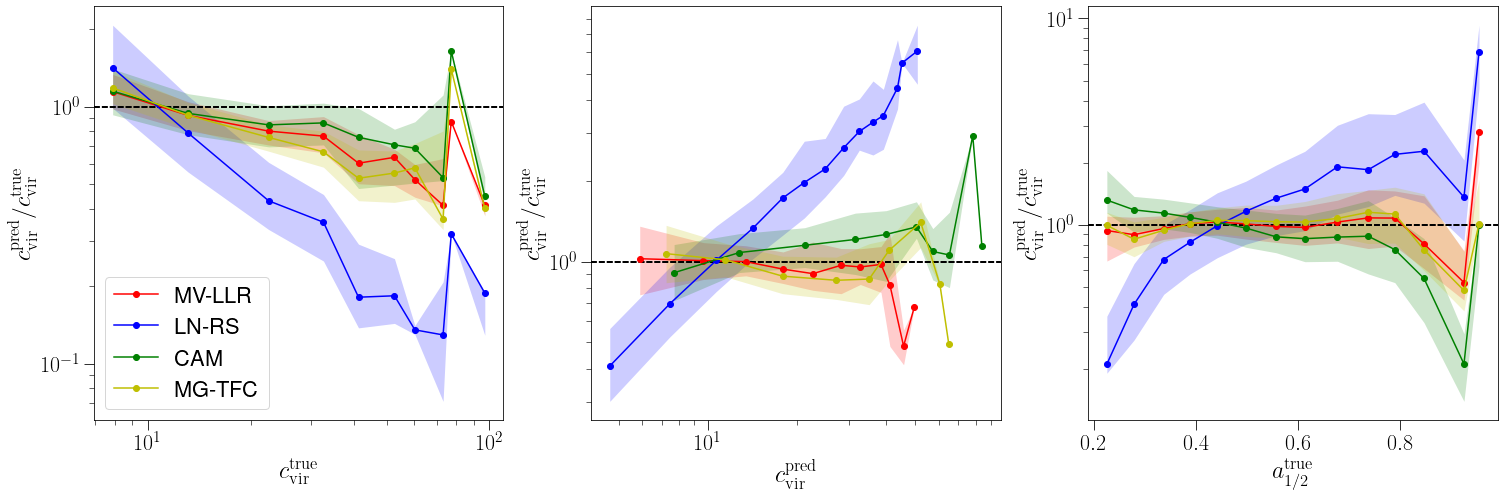

In [35]:
names = ['MV-LLR', 'LN-RS', 'CAM', 'MG-TFC']
colors = ['r', 'b', 'g', 'y']
median_bin_statistic(lam_test, cvir_test, cvir_models, names=names, colors=colors, latex_var=r'c_{\rm vir}')

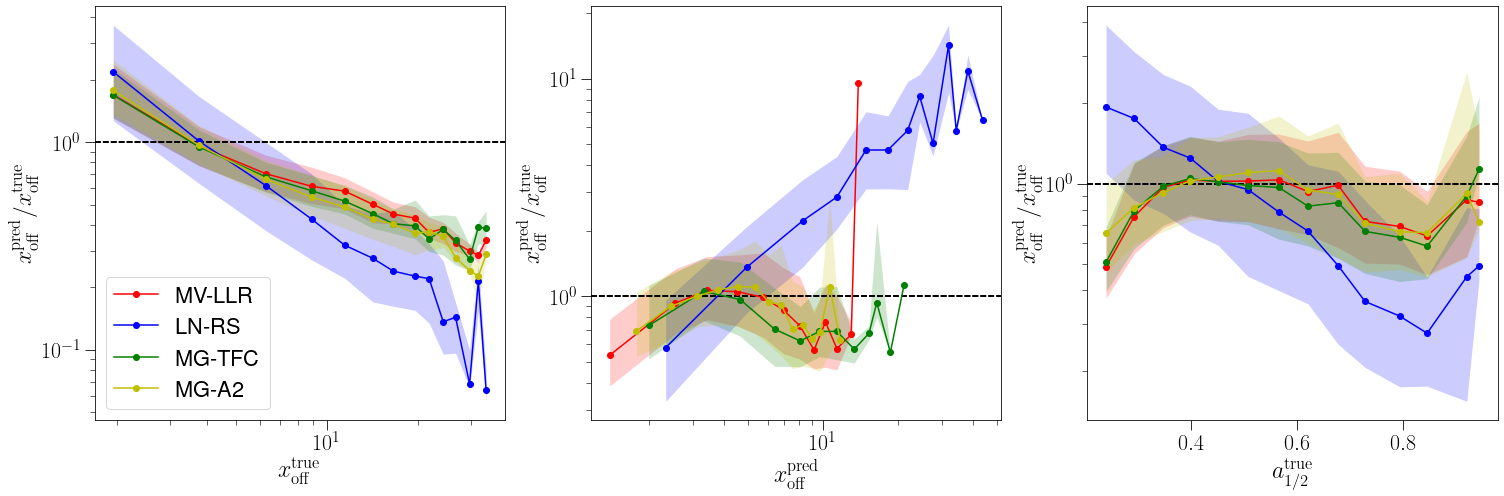

In [56]:
names = ['MV-LLR', 'LN-RS', 'MG-TFC', "MG-A2"]
colors = ['r', 'b', 'g', 'y']
median_bin_statistic(lam_test, xoff_test, xoff_models, names=names, colors=colors, latex_var=r'x_{\rm off}')

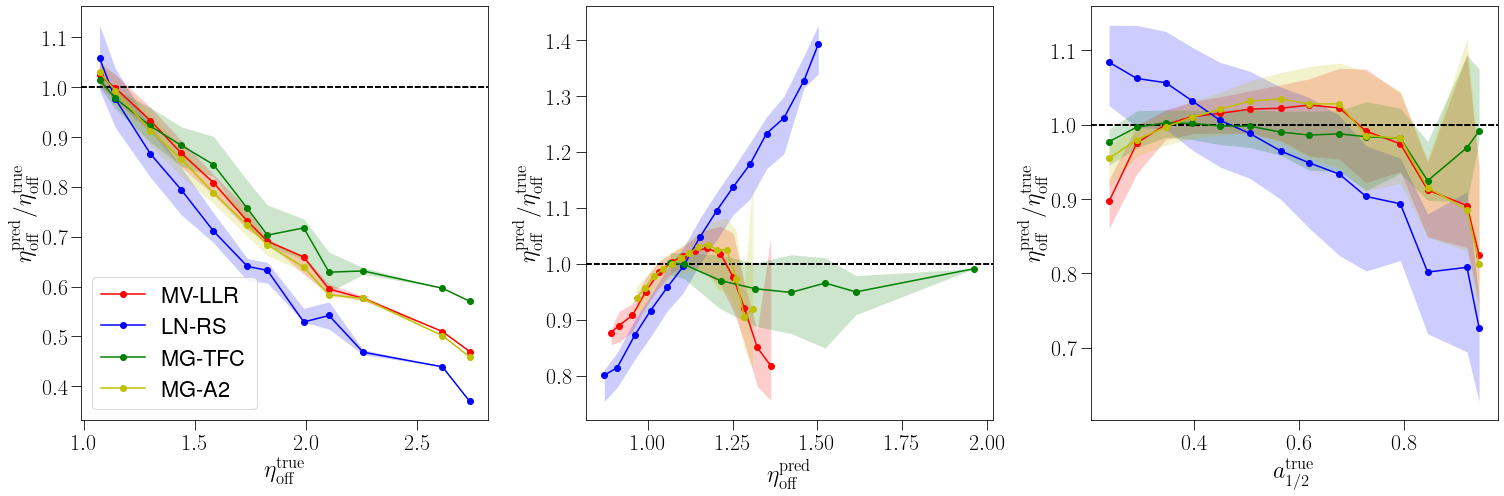

In [59]:
names = ['MV-LLR', 'LN-RS', 'MG-TFC', "MG-A2"]
colors = ['r', 'b', 'g', 'y']
median_bin_statistic(lam_test, eta_test, eta_models, names=names, colors=colors, latex_var=r'\eta_{\rm off}', log_scale=False)